### Same as 02, but working on continuous probabilities, instead of predicted classes

In [276]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [277]:
from src.utils.Preprocessing import Preprocessing
from sklearn.model_selection import train_test_split
from pickle import dump, load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

from src.bias.FreqVsFreqBiasDetector import FreqVsFreqBiasDetector
from src.bias.FreqVsRefBiasDetector import FreqVsRefBiasDetector

## Importing Data and Trained Classifier

**UX**: 
- the user uploads the dataset with the features (X)
- the user uploads 
    - the sklearn model as pkl file **or**
    - a file with the predictions already created (Y). 
- the user uploads scaler and ohe (if needed)

If a model is provided, the application checks if the the provided datasets and model match in terms of column names. 

In [278]:
input_data_path = "../data/raw_data/uci-default-of-credit-card/data/data.csv"
local_path_save = '../data/mlflow_artifacts/'

In [279]:
fitted_ohe = load(open(local_path_save + '_ohe.pkl', 'rb')) 
fitted_scaler = load(open(local_path_save + '_scaler.pkl', 'rb'))

In [280]:
pp = Preprocessing(input_data_path, "default")
X, Y = pp.read_dataframe()

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=420)

X_test_ohe, _, _ = pp.preprocess_for_classification(df=X_test, 
                                                fit_ohe=True, 
                                                fitted_ohe=fitted_ohe,
                                                perform_scaling=True,
                                                fitted_scaler=fitted_scaler)

In [281]:
with open("trained_model_for_testing/RF_12_200.pkl", "rb") as file:
    classifier = load(file)

/home/dev/repos/venv_gen_purpose/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/dev/repos/venv_gen_purpose/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [282]:
predicted_prob = classifier.predict_proba(X_test_ohe)
predicted_values = classifier.predict(X_test_ohe)

#### Definition of conditioning variables
**UX**:
- the user selects the continuous features to be categorized and used for the creation of control groups. 

The application propose splitting cuts that make the resulting discrete distribution uniform (but also other binning procedures are possible). 

In [283]:
def age_buckets(x):
    if x < 30:
        return 1
    elif x < 40:
        return 2
    else:
        return 3

X_test['age_buckets'] = X.x5_age.apply(age_buckets)

**UX**:
- the user selects from a drop down menu the variables to be used for the groups creation
- the user can select "check all the variables" and the application will use all the available discrete features

In [284]:
conditioning_variables = ['x3_education', 'x4_marriage', 'age_buckets']

In [285]:
df_with_predictions = X_test.reset_index(drop=True).assign(predictions=predicted_values, predicted_probs=predicted_prob[:,1])

In [286]:
#df_with_predictions.to_csv("data_for_demo_with_predictions.csv")

## COMPUTE EMPIRICAL PROBABILITY DENSITY FUNCTION

First of all, let's plot the histogram with density = True (the area of the bar is the relative frequency, aka the height is the probability density)

In [287]:
n_bins=10
# force range to [0 1] (instead of observed min and max), even if there are no data at the extremes, since we are modeling a probability
min_range, max_range = 0,1

Text(0.5, 1.0, 'Distribution of predicted_probs')

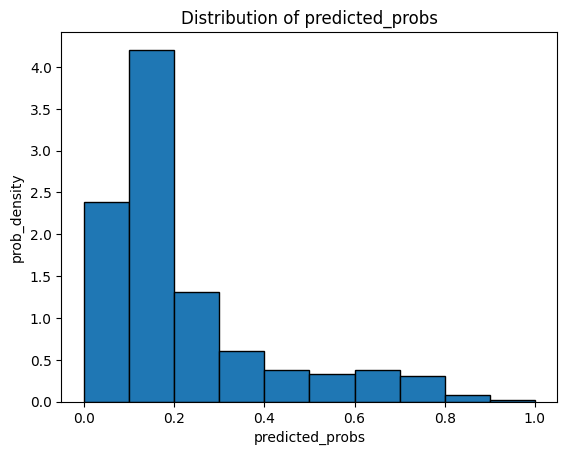

In [288]:
plt.hist(df_with_predictions['predicted_probs'], bins=n_bins, range=(min_range,max_range), edgecolor='black', density=True)
plt.xlabel('predicted_probs')
plt.ylabel('prob_density')
plt.title('Distribution of predicted_probs')

Let's extract the actual probability densities that we will use for computations

1.0000000000000002


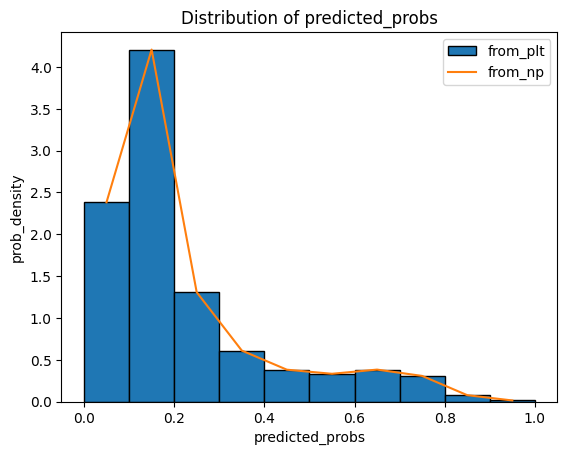

In [289]:
prob_densities, bin_edges = np.histogram(df_with_predictions['predicted_probs'], bins=n_bins, range=(min_range,max_range), density=True)
bin_width = (max_range-min_range)/n_bins
#check that the 'integral' of the PDF equals 1
print((prob_densities*bin_width).sum())

#plot the PDF, along with the previous histogram (they are the same)
#bin_edges has one dimension more than hist_values. For representation, let's compute the median value of each consecutive pair of bin edges
median_points = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.hist(df_with_predictions['predicted_probs'], bins=n_bins, range=(min_range,max_range), edgecolor='black', density=True, label='from_plt')
plt.plot(median_points,prob_densities, label='from_np')
plt.xlabel('predicted_probs')
plt.ylabel('prob_density')
plt.title('Distribution of predicted_probs')
plt.legend()
plt.show()

## Smooth the PDF

Some bins could be empty. EMpty bins will cause the computation of the KL divergence impossible: remember that KL = np.sum(p*log(p/q)) --> if p[i] != 0 and q[i]=0 we get expression of the type  p*log(p/0) that is not defined (0*log(0) is 0 for limit calculus)

There are two common used options

    - ignore bins where  q[i] is 0 (the contribution to the KL is 0 for those bins)
    - smooth the PDF, e.g. using Kernel Density Estimate methods. We are doing it now
    (other methods to test: Dirichlet smoothing, Laplace smoothing) TBD

/home/dev/repos/venv_gen_purpose/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


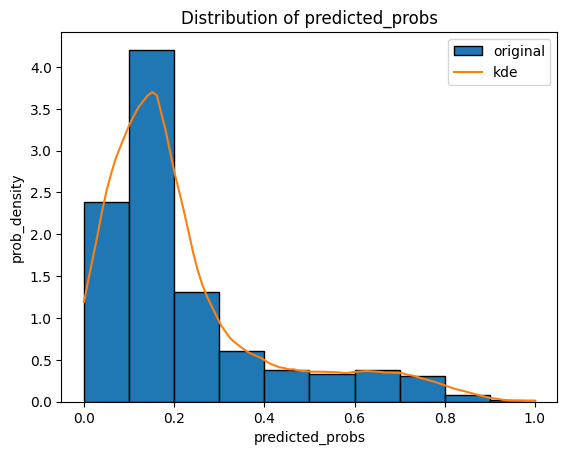

In [290]:
# if kernel ='Gaussian, suggested bandwidth='scott' --> bandwidth = n**(-1./(d+4)), wher n= number of observations, d=number of dimensions (1 in our case, since the only input is predicted_prob)
# if using kernel='tophat' (rectangular kernel) I suggest bandwidth=bin_width
model = KernelDensity(bandwidth=bin_width, kernel='tophat')
model.fit(df_with_predictions[['predicted_probs']])
# compute smoothed prob. densities on the predicted_probs range, on a number of equally distantiated points
n_bins_kde = n_bins*10
x_to_predict = np.linspace(min_range, max_range, n_bins_kde)[:, np.newaxis] #dimesion must be the same of the fit input
prob_kde = np.exp(model.score_samples(x_to_predict))

#plot smoothed pdf, along with the original pdf
plt.hist(df_with_predictions['predicted_probs'], bins=n_bins, range=(min_range,max_range), edgecolor='black', density=True, label='original')
plt.plot(x_to_predict[:,0],prob_kde, label='kde')
plt.xlabel('predicted_probs')
plt.ylabel('prob_density')
plt.title('Distribution of predicted_probs')
plt.legend()
plt.show()

### The integral of the kde pdf is not 1 on our range!

Infact, for its nature, the kde could produce non zero probabilities also outside the range of data used for fitting

/home/dev/repos/venv_gen_purpose/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


integral on original range =  0.9741358024692508


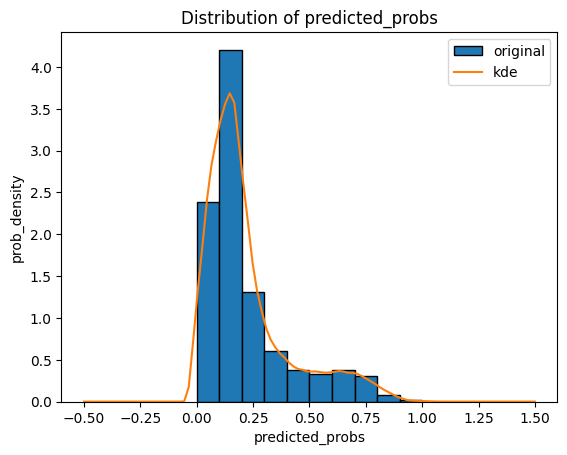

integral on wider range =  0.999517396184179


In [291]:
#use trapeziodal rule for numerical integration
print('integral on original range = ', np.trapz(prob_kde,x_to_predict[:,0]))

#let's print kde pdf also outside the above range
min_range_new, max_range_new = -0.5,1.5
x_to_predict_new = np.linspace(min_range_new, max_range_new, n_bins_kde)[:, np.newaxis]
prob_kde_new = np.exp(model.score_samples(x_to_predict_new))
plt.hist(df_with_predictions['predicted_probs'], bins=n_bins, range=(min_range,max_range), edgecolor='black', density=True, label='original')
plt.plot(x_to_predict_new[:,0],prob_kde_new, label='kde')
plt.xlabel('predicted_probs')
plt.ylabel('prob_density')
plt.title('Distribution of predicted_probs')
plt.legend()
plt.show()

print('integral on wider range = ', np.trapz(prob_kde_new,x_to_predict_new[:,0]))

## Let's nomralize it on the 0 1 range

Integral of normalized kde =  1.0


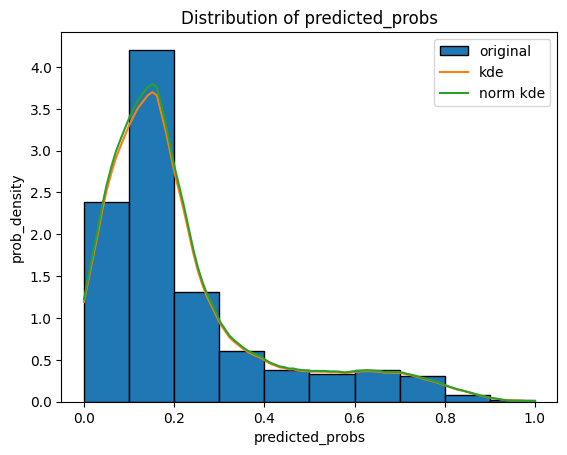

In [292]:
norm_factor = np.trapz(prob_kde,x_to_predict[:,0])
prob_kde_norm = prob_kde/norm_factor
print('Integral of normalized kde = ', np.trapz(prob_kde_norm,x_to_predict[:,0]))

#plot normalized kde, along with the original pdf
plt.hist(df_with_predictions['predicted_probs'], bins=n_bins, range=(min_range,max_range), edgecolor='black', density=True, label='original')
plt.plot(x_to_predict[:,0],prob_kde, label='kde')
plt.plot(x_to_predict[:,0],prob_kde_norm, label='norm kde')
plt.xlabel('predicted_probs')
plt.ylabel('prob_density')
plt.title('Distribution of predicted_probs')
plt.legend()
plt.show()

## Compute discrete PDFs
Switch from pdfs p(x) to discrete pdfs P(x in bin_i), so we can use the same fucntions to calculate divergences

[0.23822222 0.42077778 0.13077778 0.061      0.03811111 0.03322222
 0.03822222 0.03066667 0.00766667 0.00133333]
[2144 3787 1177  549  343  299  344  276   69   12]
[0.23822222 0.42077778 0.13077778 0.061      0.03811111 0.03322222
 0.03822222 0.03066667 0.00766667 0.00133333]
sum of discr_prob_densities =  1.0000000000000002
sum of discr_prob_kde =  0.9999999999999999


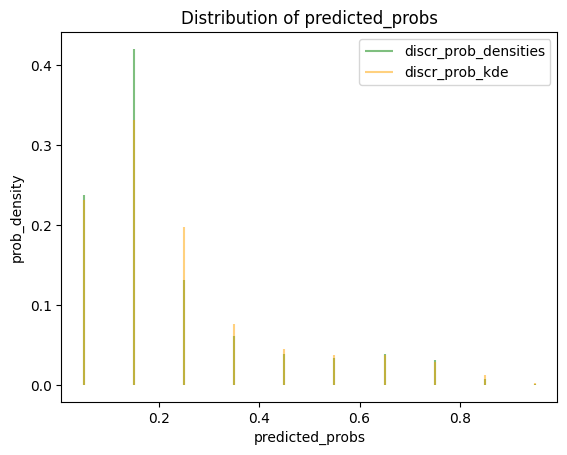

In [321]:
discr_prob_densities = prob_densities*bin_width
# or equvalently
#discr_prob_densities, _ = np.histogram(df_with_predictions['predicted_probs'], bins=n_bins, range=(min_range,max_range), density=False)
#discr_prob_densities =  discr_prob_densities/len(df_with_predictions['predicted_probs'])

print('sum of discr_prob_densities = ', sum(discr_prob_densities))


def discr_kde(bin_edges, x_to_predict, prob_kde):
    '''
    Given the pdf prob_kde (where each probability value is associated to an element of x_to_predict), discretize it (aka compute p(x)*dx, using the trapezoidal rule),
    eventually using bins that are different from the ones defined by x_to_predict: use bin_edges instead (bin_edges can equal x_to_predict)
    '''
    discr_prob_densities = []

    for i in range(len(bin_edges) - 1):
        
        start_edge = bin_edges[i]
        end_edge = bin_edges[i + 1]
        dx = end_edge - start_edge
        # Find indices within the range defined by bin edges
        indices = np.where((x_to_predict >= start_edge) & (x_to_predict < end_edge))[0]
        if i == (len(bin_edges) - 2):
            indices = np.where((x_to_predict >= start_edge) & (x_to_predict <= end_edge))[0]

        #print(indices)

        discr_prob_densities.append(dx*(prob_kde[indices[-1]] + prob_kde[indices[0]])/2)
        #discr_prob_densities.append(dx*np.mean(prob_kde[indices]))

    #correction: discrete integration (especially on bins wider than the original ones) could cause the discrete pdf not to sum exactly to one
    discr_prob_densities = np.array(discr_prob_densities)/(np.sum(discr_prob_densities))
    return discr_prob_densities

        
    
discr_prob_kde = discr_kde(bin_edges, x_to_predict[:,0], prob_kde_norm)
print('sum of discr_prob_kde = ',discr_prob_kde.sum())



#plot normalized kde, along with the original pdf
#plt.hist(df_with_predictions['predicted_probs'], bins=n_bins, range=(min_range,max_range), edgecolor='black', density=True, label='original')
plt.vlines(median_points, ymin=0, ymax=discr_prob_densities, label='discr_prob_densities', color='green', alpha=0.5)
plt.vlines(median_points, ymin=0, ymax=discr_prob_kde, label='discr_prob_kde', color='orange', alpha=0.5)
plt.xlabel('predicted_probs')
plt.ylabel('prob_density')
plt.title('Distribution of predicted_probs')
plt.legend()
plt.show()

## FINE PROVE

## Bias Detection

**UX**:
- the user selects from a drop down menu the binary variable to be used for the distance calculation
- the user selects a threshold for the distance
- the user selects a Distance (if more than one are provided)

In [294]:
bd = FreqVsFreqBiasDetector(distance="TVD")

**UX**:

The user has can select between two options:
- Option 1: distance between frequencies
- Option 2: distance from reference distribution
    - in this case, the user has to insert values for a reference distribution

## Option 1: Distance between frequencies

### Comparison of the two groups observed freqs

In [295]:
bd.compare_root_variable_groups(
    dataframe=df_with_predictions,
    target_variable='predictions',
    root_variable='x2_sex',
    threshold=0.1
)

(0.025269625352224545, True, 0.1, None)

In [296]:
#distance = max( abs(female_0_freq - male_0_freq), abs(female_1_freq - male_1_freq) )

In [311]:
df_with_predictions.groupby("x2_sex").predictions.value_counts(normalize=True)

x2_sex  predictions
1       0              0.873592
        1              0.126408
2       0              0.898862
        1              0.101138
Name: predictions, dtype: float64

### Comparison of the two groups observed freqs conditioning to other features

In [298]:
results = bd.compare_root_variable_conditioned_groups(
    dataframe=df_with_predictions,
    target_variable='predictions',
    root_variable='x2_sex',
    conditioning_variables=conditioning_variables,
    threshold=0.1,
    min_obs_per_group=30)

In [299]:
results

{'x3_education==1': (3119, 0.0183300648997351, True, 0.1, None),
 'x3_education==3': (1499, 0.03290896164530149, True, 0.1, None),
 'x3_education==2': (4250, 0.030006620324395897, True, 0.1, None),
 'x3_education==4': (40, 0.0, True, 0.1, None),
 'x3_education==5': (75, 0.06772575250836121, True, 0.1, None),
 'x3_education==6': (14, None, 'Not enough observations'),
 'x3_education==0': (3, None, 'Not enough observations'),
 'x4_marriage==1': (4065, 0.019241036358938257, True, 0.1, None),
 'x4_marriage==2': (4822, 0.03149828894509746, True, 0.1, None),
 'x4_marriage==3': (95, 0.05425219941348974, True, 0.1, None),
 'x4_marriage==0': (18, None, 'Not enough observations'),
 'age_buckets==3': (2727, 0.01788279719173691, True, 0.1, None),
 'age_buckets==1': (2895, 0.009266981744045971, True, 0.1, None),
 'age_buckets==2': (3378, 0.047657731623916205, True, 0.1, None),
 'x3_education==1 & x4_marriage==1': (1106,
  0.02132550290983498,
  True,
  0.1,
  None),
 'x3_education==1 & x4_marriage==

**UX**:
- the application shows the results in two views:
    - overall results: all the computed distances
    - violations: only the results above the threshold
- for both, the user can order the results by number of obs, distance or group name

In [313]:
# selecting only combinations for which the distance is greater than the threshold 
violations = {k: v for k, v in results.items() if not v[2]}
violations

{}

- '2: Gender (1 = male; 2 = female).',
- '3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).',
- '4: Marital status (1 = married; 2 = single; 3 = others).'

In [314]:
# sorting the violations by number of observations belonging to that group
dict(sorted(violations.items(), key=lambda item: item[1], reverse=True))

{}

#### Focus analyses on particular cases
Here we want to understand/qualify some specific violation cases.

**UX**: 
- the user selects one of the available violations
- the application returns relevant details to help understand what's going on
- the user can download the results as csv file. 

In [302]:
focus_df = df_with_predictions.query("x3_education==3 & x4_marriage==2 & age_buckets==2")
bd.get_frequencies_list(focus_df, 'predictions', 
                        df_with_predictions.predictions.unique(),
                        'x2_sex', df_with_predictions.x2_sex.unique())

([array([0.94252874, 0.05747126]), array([0.83333333, 0.16666667])],
 [array([82,  5]), array([85, 17])])

In [303]:
focus_df.groupby('x2_sex').predictions.value_counts(normalize=True)

x2_sex  predictions
1       0              0.833333
        1              0.166667
2       0              0.942529
        1              0.057471
Name: predictions, dtype: float64

## Option 2: distance from reference distribution

In [304]:
bd = FreqVsRefBiasDetector()

In [305]:
male_0_ref = 75/100
male_1_ref = 25/100

female_0_ref = 75/100
female_1_ref = 25/100

ref_distribution = [np.array([female_0_ref, female_1_ref]), np.array([male_0_ref, male_1_ref])]

### Comparison of the two groups w.r.t. the reference distribution

In [306]:
bd.compare_root_variable_groups(
    dataframe=df_with_predictions,
    target_variable='predictions',
    root_variable='x2_sex',
    threshold=0.1,
    reference_distribution=ref_distribution
)

([0.11543085607355452, 0.07485260878313427], [False, True], 0.1)

### Comparison of the two groups w.r.t. the reference distribution conditioning to other features

In [307]:
results = bd.compare_root_variable_conditioned_groups(
    dataframe=df_with_predictions,
    target_variable='predictions',
    root_variable='x2_sex',
    conditioning_variables=conditioning_variables,
    threshold=0.1,
    min_obs_per_group=30,
    reference_distribution=ref_distribution)

In [308]:
results

{'x3_education==1': (3119,
  [0.19953637846872263, 0.15292885987559768],
  [False, False],
  0.1),
 'x3_education==3': (1499,
  [0.06683511671201015, 0.03232914493273209],
  [True, True],
  0.1),
 'x3_education==2': (4250,
  [0.08642530432448603, 0.04817486426708861],
  [True, True],
  0.1),
 'x3_education==4': (40, [1.0, 1.0], [False, False], 0.1),
 'x3_education==5': (75,
  [0.38832031424465063, 0.14386916131129301],
  [False, False],
  0.1),
 'x3_education==6': (14, None, 'Not enough observations'),
 'x3_education==0': (3, None, 'Not enough observations'),
 'x4_marriage==1': (4065,
  [0.10973782259615394, 0.07892104655259335],
  [False, True],
  0.1),
 'x4_marriage==2': (4822,
  [0.12158030611282034, 0.07082922204298259],
  [False, True],
  0.1),
 'x4_marriage==3': (95,
  [0.0516801997479408, 0.13547714823554813],
  [True, False],
  0.1),
 'x4_marriage==0': (18, None, 'Not enough observations'),
 'age_buckets==3': (2727,
  [0.10037160327202987, 0.07325935937033368],
  [False, True],

In [309]:
# selecting only combinations for which the distance is greater than the threshold 
violations = {k: v for k, v in results.items() if (not v[2][0] or not v[2][1])}

In [310]:
violations

{'x3_education==1': (3119,
  [0.19953637846872263, 0.15292885987559768],
  [False, False],
  0.1),
 'x3_education==4': (40, [1.0, 1.0], [False, False], 0.1),
 'x3_education==5': (75,
  [0.38832031424465063, 0.14386916131129301],
  [False, False],
  0.1),
 'x4_marriage==1': (4065,
  [0.10973782259615394, 0.07892104655259335],
  [False, True],
  0.1),
 'x4_marriage==2': (4822,
  [0.12158030611282034, 0.07082922204298259],
  [False, True],
  0.1),
 'x4_marriage==3': (95,
  [0.0516801997479408, 0.13547714823554813],
  [True, False],
  0.1),
 'age_buckets==3': (2727,
  [0.10037160327202987, 0.07325935937033368],
  [False, True],
  0.1),
 'age_buckets==2': (3378,
  [0.17187679217619678, 0.08024299977384175],
  [False, True],
  0.1),
 'x3_education==1 & x4_marriage==1': (1106,
  [0.23477269281627888, 0.1732719966909978],
  [False, False],
  0.1),
 'x3_education==1 & x4_marriage==2': (2002,
  [0.18238653638283597, 0.14048573698048983],
  [False, False],
  0.1),
 'x3_education==5 & x4_marriage=